In [1]:
from pathlib import Path
from ardi.dataset import SocialVAEDataset
import numpy as np
from ardi.prediction import LinearPredictor, PowerlawPredictor, SocialVAEPredictor, VelocityCalc, PrefVelocityCalc

/home/alex/.local/share/virtualenvs/ardi-RqNcZ39U/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_ds = SocialVAEDataset("../../SocialVAE/data/zucker_day_controller_scene/19/cadrl/overtake/23_0.txt")

In [3]:
lp = LinearPredictor(8, VelocityCalc.LAST_DISPLACEMENT)
pp = PowerlawPredictor(8, VelocityCalc.LAST_DISPLACEMENT, PrefVelocityCalc.FIX_MAG_ORACLE_DIR)
sp = SocialVAEPredictor("../../SocialVAE/models/zara01/ckpt-best", 4, 5, 8, VelocityCalc.LAST_DISPLACEMENT)
predictors = {
    "Linear": lp,
    "Powerlaw": pp,
    "SocialVAE": sp
}

lp_ades, lp_fdes = lp.predict_dataset(test_ds, 5, [i for i in test_ds.agents if i != -1], False)
pp_ades, pp_fdes = pp.predict_dataset(test_ds, 5, [i for i in test_ds.agents if i != -1], False)
sp_ades, sp_fdes = sp.predict_dataset(test_ds, 5, [i for i in test_ds.agents if i != -1], False)

print(np.mean(lp_ades), np.mean(lp_fdes))
print(np.mean(pp_ades), np.mean(pp_fdes))
print(np.mean(sp_ades), np.mean(sp_fdes))

0.3145340106836143 0.7124782817872577
0.2297543604784849 0.37006448538139813
0.20786477077296284 0.43129064850663734


In [7]:
from tqdm import tqdm
results = {}

for i, fn in tqdm(list(enumerate(Path("../../SocialVAE/data/zucker_day_controller_scene/").glob("./*/cadrl/*/*txt")))):
    ds = SocialVAEDataset(str(fn))
    results[str(fn)] = {}
    
    for name in predictors:
        ades, fdes = predictors[name].predict_dataset(ds, 5, [i for i in ds.agents if i != -1])

        results[str(fn)][name] = (ades, fdes)

  2%|▏         | 20/816 [03:08<2:04:45,  9.40s/it]


KeyboardInterrupt: 

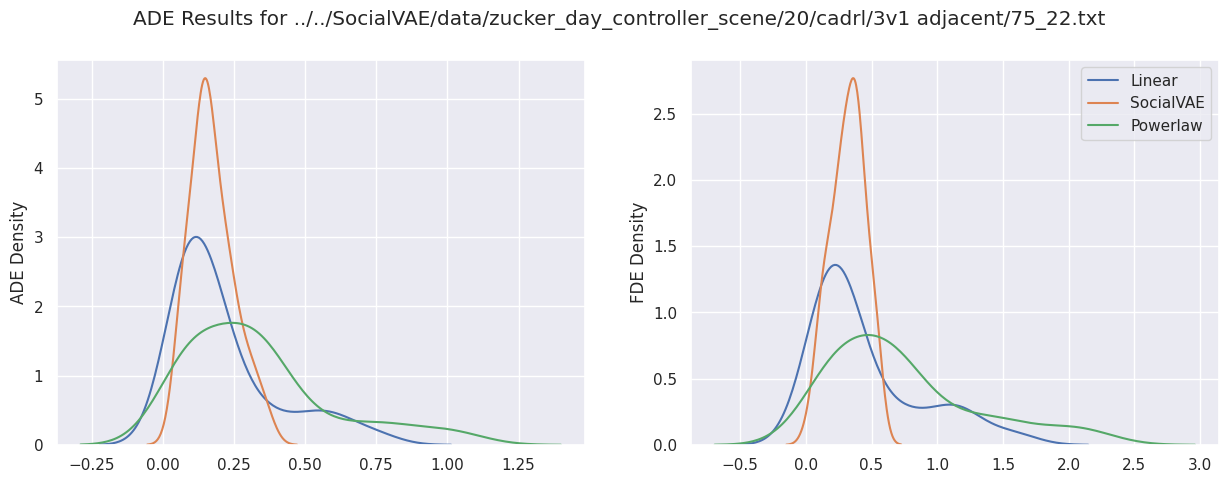

In [49]:
from pprint import pprint
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plot_fn = sns.kdeplot

print()

plot_fn([x for x in [results[key]["Linear"][0] for key in results] for x in x], label="Linear", ax=axs[0])
plot_fn([x for x in [results[key]["SocialVAE"][0] for key in results] for x in x], label="SocialVAE", ax=axs[0])
plot_fn([x for x in [results[key]["Powerlaw"][0] for key in results] for x in x], label="Powerlaw", ax=axs[0])

plot_fn([x for x in [results[key]["Linear"][1] for key in results] for x in x], label="Linear", ax=axs[1])
plot_fn([x for x in [results[key]["SocialVAE"][1] for key in results] for x in x], label="SocialVAE", ax=axs[1])
plot_fn([x for x in [results[key]["Powerlaw"][1] for key in results] for x in x], label="Powerlaw", ax=axs[1])

axs[0].set_ylabel("ADE Density")
axs[1].set_ylabel("FDE Density")

plt.suptitle(f"ADE Results for CADRL")
plt.legend()
